In [1]:
!pip install quantecon interpolation

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams["figure.figsize"] = (11, 5)  #set default figure size
import numpy as np
from numba import njit, prange, float64, int64
from numba.experimental import jitclass
from interpolation import interp
from math import gamma
from scipy.optimize import minimize

/Users/humphreyyang/anaconda3/envs/quantecon/lib/python3.9/site-packages/numba/core/decorators.py:262: NumbaDeprecationWarning: numba.generated_jit is deprecated. Please see the documentation at: https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-generated-jit for more information and advice on a suitable replacement.
  warnings.warn(msg, NumbaDeprecationWarning)


In [3]:
@njit
def p(x, a, b):
    "Beta distribution."

    r = gamma(a + b) / (gamma(a) * gamma(b))

    return r * x**(a-1) * (1 - x)**(b-1)

In [4]:
wf_data = [
    ('c', float64),           # unemployment compensation
    ('a0', float64),          # parameters of beta distribution
    ('b0', float64),
    ('a1', float64),
    ('b1', float64),
    ('L0', float64),          # cost of selecting f0 when f1 is true
    ('L1', float64),          # cost of selecting f1 when f0 is true
    ('π_grid', float64[:]),   # grid of beliefs π
    ('π_grid_size', int64),
    ('mc_size', int64),       # size of Monto Carlo simulation
    ('z0', float64[:]),       # sequence of random values
    ('z1', float64[:])        # sequence of random values
]

In [5]:
@jitclass(wf_data)
class WaldFriedman:

    def __init__(self,
                 c=1.25,
                 a0=1,
                 b0=1,
                 a1=3,
                 b1=1.2,
                 L0=100,
                 L1=100,
                 π_grid_size=200,
                 mc_size=1000):

        self.c, self.π_grid_size = c, π_grid_size
        self.a0, self.b0, self.a1, self.b1 = a0, b0, a1, b1
        self.L0, self.L1 = L0, L1
        self.π_grid = np.linspace(0, 1, π_grid_size)
        self.mc_size = mc_size

        self.z0 = np.random.beta(a0, b0, mc_size)
        self.z1 = np.random.beta(a1, b1, mc_size)

    def f0(self, x):

        return p(x, self.a0, self.b0)

    def f1(self, x):

        return p(x, self.a1, self.b1)

    def κ(self, z, π):
        """
        Updates π using Bayes' rule and the current observation z
        """

        a0, b0, a1, b1 = self.a0, self.b0, self.a1, self.b1

        π_f0, π_f1 = π * p(z, a0, b0), (1 - π) * p(z, a1, b1)
        π_new = π_f0 / (π_f0 + π_f1)

        return π_new

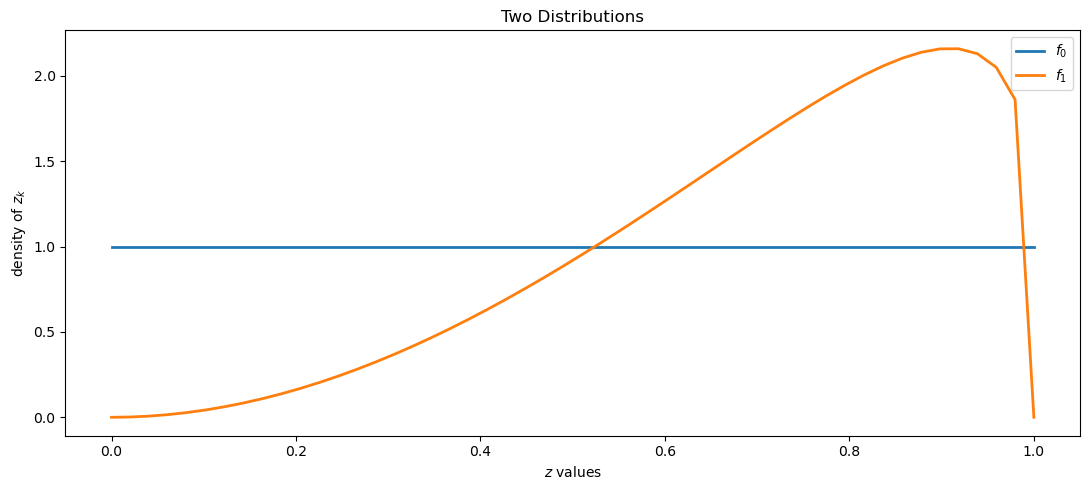

In [6]:
wf = WaldFriedman()

grid = np.linspace(0, 1, 50)

plt.figure()

plt.title("Two Distributions")
plt.plot(grid, wf.f0(grid), lw=2, label="$f_0$")
plt.plot(grid, wf.f1(grid), lw=2, label="$f_1$")

plt.legend()
plt.xlabel("$z$ values")
plt.ylabel("density of $z_k$")

plt.tight_layout()
plt.show()

In [7]:
N = 10000
T = 100

In [8]:
z0_arr = np.random.beta(wf.a0, wf.b0, (N, T))
z1_arr = np.random.beta(wf.a1, wf.b1, (N, T))

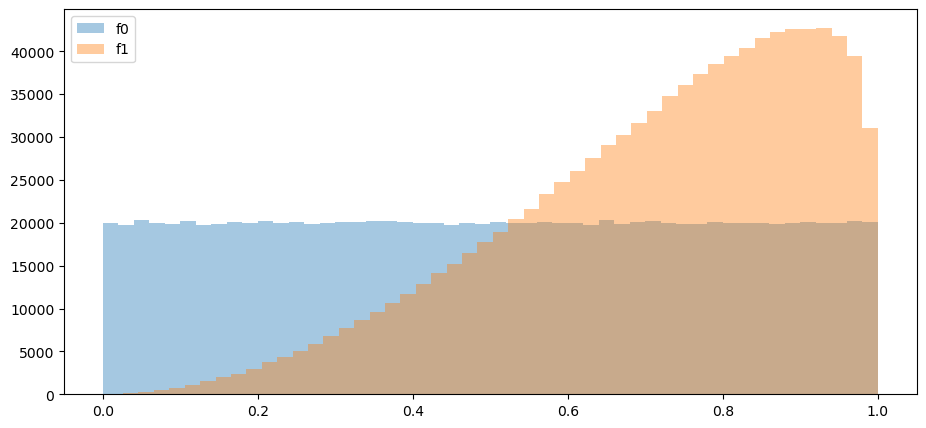

In [9]:
plt.hist(z0_arr.flatten(), bins=50, alpha=0.4, label='f0')
plt.hist(z1_arr.flatten(), bins=50, alpha=0.4, label='f1')
plt.legend()
plt.show()

In [10]:
l = lambda z: wf.f0(z) / wf.f1(z)

In [11]:
l0_arr = l(z0_arr)
l1_arr = l(z1_arr)

L0_arr = np.cumprod(l0_arr, 1)
L1_arr = np.cumprod(l1_arr, 1)

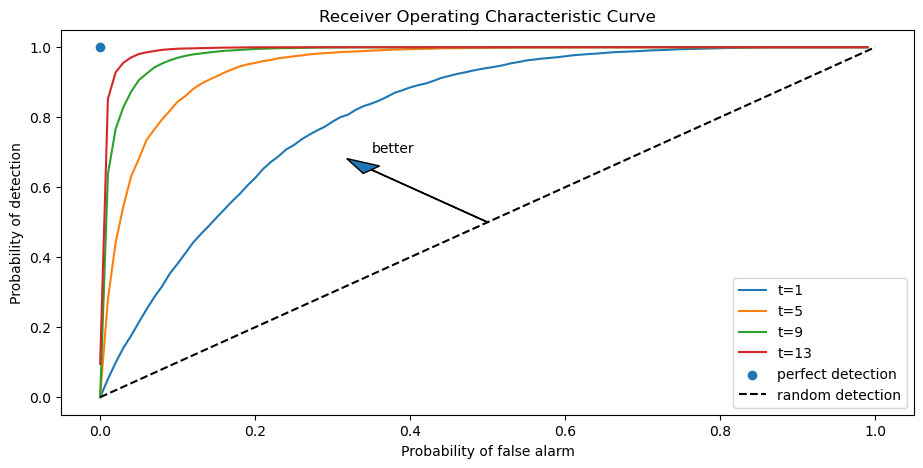

In [12]:
PFA = np.arange(0, 100, 1)

for t in range(1, 15, 4):
    percentile = np.percentile(L0_arr[:, t], PFA)
    PD = [np.sum(L1_arr[:, t] < p) / N for p in percentile]

    plt.plot(PFA / 100, PD, label=f"t={t}")

plt.scatter(0, 1, label="perfect detection")
plt.plot([0, 1], [0, 1], color='k', ls='--', label="random detection")

plt.arrow(0.5, 0.5, -0.15, 0.15, head_width=0.03)
plt.text(0.35, 0.7, "better")
plt.xlabel("Probability of false alarm")
plt.ylabel("Probability of detection")
plt.legend()
plt.title("Receiver Operating Characteristic Curve")
plt.show()

In [13]:
@njit
def V_fre_d_t(d, t, L0_arr, L1_arr, π_star, wf):

    N = L0_arr.shape[0]

    PFA = np.sum(L0_arr[:, t-1] < d) / N
    PD = np.sum(L1_arr[:, t-1] < d) / N

    V = π_star * PFA *wf. L1 + (1 - π_star) * (1 - PD) * wf.L0

    return V

In [14]:
def V_fre_t(t, L0_arr, L1_arr, π_star, wf):

    res = minimize(V_fre_d_t, 1, args=(t, L0_arr, L1_arr, π_star, wf), method='Nelder-Mead')
    V = res.fun
    d = res.x

    PFA = np.sum(L0_arr[:, t-1] < d) / N
    PD = np.sum(L1_arr[:, t-1] < d) / N

    return V, PFA, PD

In [15]:
def compute_V_fre(L0_arr, L1_arr, π_star, wf):

    T = L0_arr.shape[1]

    V_fre_arr = np.empty(T)
    PFA_arr = np.empty(T)
    PD_arr = np.empty(T)

    for t in range(1, T+1):
        V, PFA, PD = V_fre_t(t, L0_arr, L1_arr, π_star, wf)
        V_fre_arr[t-1] = wf.c * t + V
        PFA_arr[t-1] = PFA
        PD_arr[t-1] = PD

    return V_fre_arr, PFA_arr, PD_arr

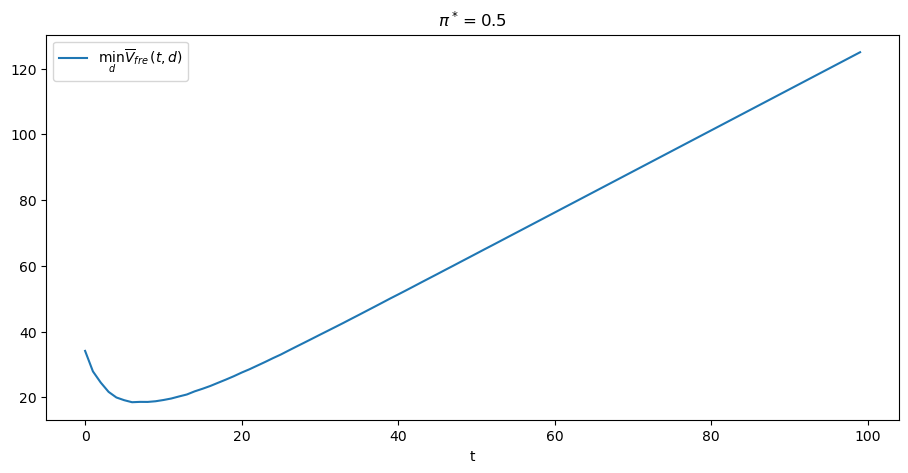

In [16]:
π_star = 0.5
V_fre_arr, PFA_arr, PD_arr = compute_V_fre(L0_arr, L1_arr, π_star, wf)

plt.plot(range(T), V_fre_arr, label='$\min_{d} \overline{V}_{fre}(t,d)$')
plt.xlabel('t')
plt.title('$\pi^*=0.5$')
plt.legend()
plt.show()

In [17]:
t_optimal = np.argmin(V_fre_arr) + 1

In [18]:
msg = f"The above graph indicates that minimizing over t tells the frequentist to draw {t_optimal} observations and then decide."
print(msg)

The above graph indicates that minimizing over t tells the frequentist to draw 7 observations and then decide.


In [19]:
n_π = 20
π_star_arr = np.linspace(0.1, 0.9, n_π)

V_fre_bar_arr = np.empty(n_π)
t_optimal_arr = np.empty(n_π)
PFA_optimal_arr = np.empty(n_π)
PD_optimal_arr = np.empty(n_π)

for i, π_star in enumerate(π_star_arr):
    V_fre_arr, PFA_arr, PD_arr = compute_V_fre(L0_arr, L1_arr, π_star, wf)
    t_idx = np.argmin(V_fre_arr)

    V_fre_bar_arr[i] = V_fre_arr[t_idx]
    t_optimal_arr[i] = t_idx + 1
    PFA_optimal_arr[i] = PFA_arr[t_idx]
    PD_optimal_arr[i] = PD_arr[t_idx]

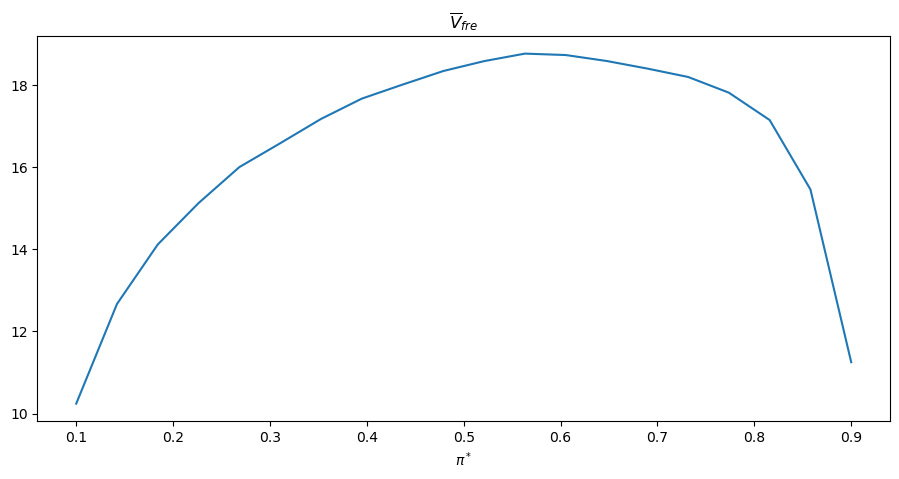

In [20]:
plt.plot(π_star_arr, V_fre_bar_arr)
plt.xlabel('$\pi^*$')
plt.title('$\overline{V}_{fre}$')

plt.show()

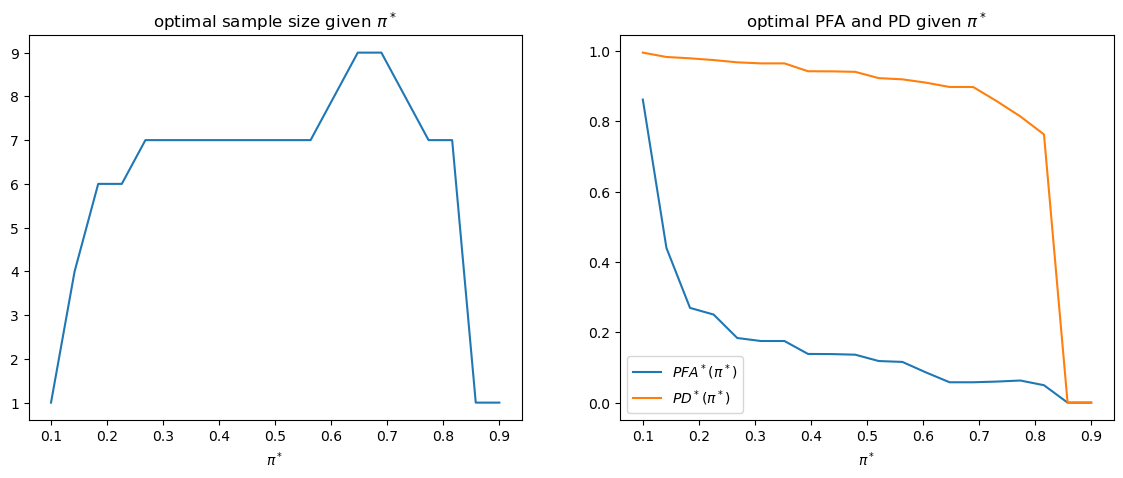

In [21]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(π_star_arr, t_optimal_arr)
axs[0].set_xlabel('$\pi^*$')
axs[0].set_title('optimal sample size given $\pi^*$')

axs[1].plot(π_star_arr, PFA_optimal_arr, label='$PFA^*(\pi^*)$')
axs[1].plot(π_star_arr, PD_optimal_arr, label='$PD^*(\pi^*)$')
axs[1].set_xlabel('$\pi^*$')
axs[1].legend()
axs[1].set_title('optimal PFA and PD given $\pi^*$')

plt.show()

In [22]:
@njit(parallel=True)
def Q(h, wf):

    c, π_grid = wf.c, wf.π_grid
    L0, L1 = wf.L0, wf.L1
    z0, z1 = wf.z0, wf.z1
    mc_size = wf.mc_size

    κ = wf.κ

    h_new = np.empty_like(π_grid)
    h_func = lambda p: interp(π_grid, h, p)

    for i in prange(len(π_grid)):
        π = π_grid[i]

        # Find the expected value of J by integrating over z
        integral_f0, integral_f1 = 0, 0
        for m in range(mc_size):
            π_0 = κ(z0[m], π)  # Draw z from f0 and update π
            integral_f0 += min((1 - π_0) * L0, π_0 * L1, h_func(π_0))

            π_1 = κ(z1[m], π)  # Draw z from f1 and update π
            integral_f1 += min((1 - π_1) * L0, π_1 * L1, h_func(π_1))

        integral = (π * integral_f0 + (1 - π) * integral_f1) / mc_size

        h_new[i] = c + integral

    return h_new

In [23]:
@njit
def solve_model(wf, tol=1e-4, max_iter=1000):
    """
    Compute the continuation value function

    * wf is an instance of WaldFriedman
    """

    # Set up loop
    h = np.zeros(len(wf.π_grid))
    i = 0
    error = tol + 1

    while i < max_iter and error > tol:
        h_new = Q(h, wf)
        error = np.max(np.abs(h - h_new))
        i += 1
        h = h_new

    if error > tol:
        print("Failed to converge!")

    return h_new

In [24]:
h_star = solve_model(wf)

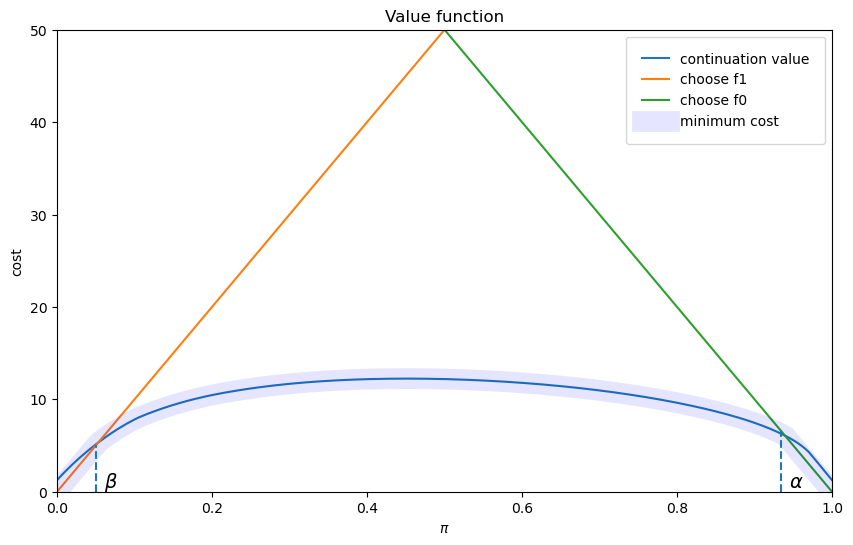

In [25]:
@njit
def find_cutoff_rule(wf, h):

    """
    This function takes a continuation value function and returns the
    corresponding cutoffs of where you transition between continuing and
    choosing a specific model
    """

    π_grid = wf.π_grid
    L0, L1 = wf.L0, wf.L1

    # Evaluate cost at all points on grid for choosing a model
    payoff_f0 = (1 - π_grid) * L0
    payoff_f1 = π_grid * L1

    # The cutoff points can be found by differencing these costs with
    # The Bellman equation (J is always less than or equal to p_c_i)
    β = π_grid[np.searchsorted(
                              payoff_f1 - np.minimum(h, payoff_f0),
                              1e-10)
               - 1]
    α = π_grid[np.searchsorted(
                              np.minimum(h, payoff_f1) - payoff_f0,
                              1e-10)
               - 1]

    return (β, α)

β, α = find_cutoff_rule(wf, h_star)
cost_L0 = (1 - wf.π_grid) * wf.L0
cost_L1 = wf.π_grid * wf.L1

fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(wf.π_grid, h_star, label='continuation value')
ax.plot(wf.π_grid, cost_L1, label='choose f1')
ax.plot(wf.π_grid, cost_L0, label='choose f0')
ax.plot(wf.π_grid,
        np.amin(np.column_stack([h_star, cost_L0, cost_L1]),axis=1),
        lw=15, alpha=0.1, color='b', label='minimum cost')

ax.annotate(r"$\beta$", xy=(β + 0.01, 0.5), fontsize=14)
ax.annotate(r"$\alpha$", xy=(α + 0.01, 0.5), fontsize=14)

plt.vlines(β, 0, β * wf.L0, linestyle="--")
plt.vlines(α, 0, (1 - α) * wf.L1, linestyle="--")

ax.set(xlim=(0, 1), ylim=(0, 0.5 * max(wf.L0, wf.L1)), ylabel="cost",
       xlabel="$\pi$", title="Value function")

plt.legend(borderpad=1.1)
plt.show()

In [26]:
@njit(parallel=True)
def V_q(wf, flag):
    V = np.zeros(wf.π_grid_size)
    if flag == 0:
        z_arr = wf.z0
        V[wf.π_grid < β] = wf.L1
    else:
        z_arr = wf.z1
        V[wf.π_grid >= α] = wf.L0

    V_old = np.empty_like(V)

    while True:
        V_old[:] = V[:]
        V[(β <= wf.π_grid) & (wf.π_grid < α)] = 0

        for i in prange(len(wf.π_grid)):
            π = wf.π_grid[i]

            if π >= α or π < β:
                continue

            for j in prange(len(z_arr)):
                π_next = wf.κ(z_arr[j], π)
                V[i] += wf.c + interp(wf.π_grid, V_old, π_next)

            V[i] /= wf.mc_size

        if np.abs(V - V_old).max() < 1e-5:
            break

    return V

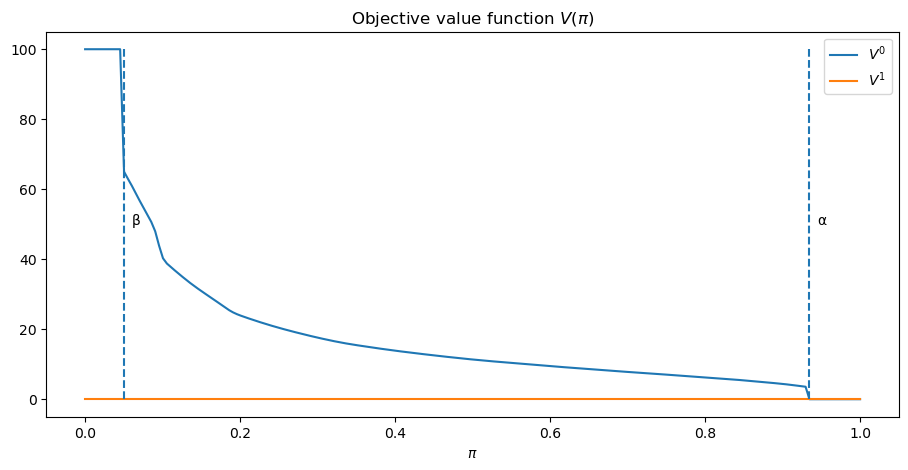

In [27]:
V0 = V_q(wf, 0)
V1 = V_q(wf, 1)

plt.plot(wf.π_grid, V0, label='$V^0$')
plt.plot(wf.π_grid, V1, label='$V^1$')
plt.vlines(β, 0, wf.L0, linestyle='--')
plt.text(β+0.01, wf.L0/2, 'β')
plt.vlines(α, 0, wf.L0, linestyle='--')
plt.text(α+0.01, wf.L0/2, 'α')
plt.xlabel('$\pi$')
plt.title('Objective value function $V(\pi)$')
plt.legend()
plt.show()

In [28]:
def compute_V_baye_bar(π_star, V0, V1, wf):

    V_baye = π_star * V0 + (1 - π_star) * V1
    π_idx = np.argmin(V_baye)
    π_optimal = wf.π_grid[π_idx]
    V_baye_bar = V_baye[π_idx]

    return V_baye, π_optimal, V_baye_bar

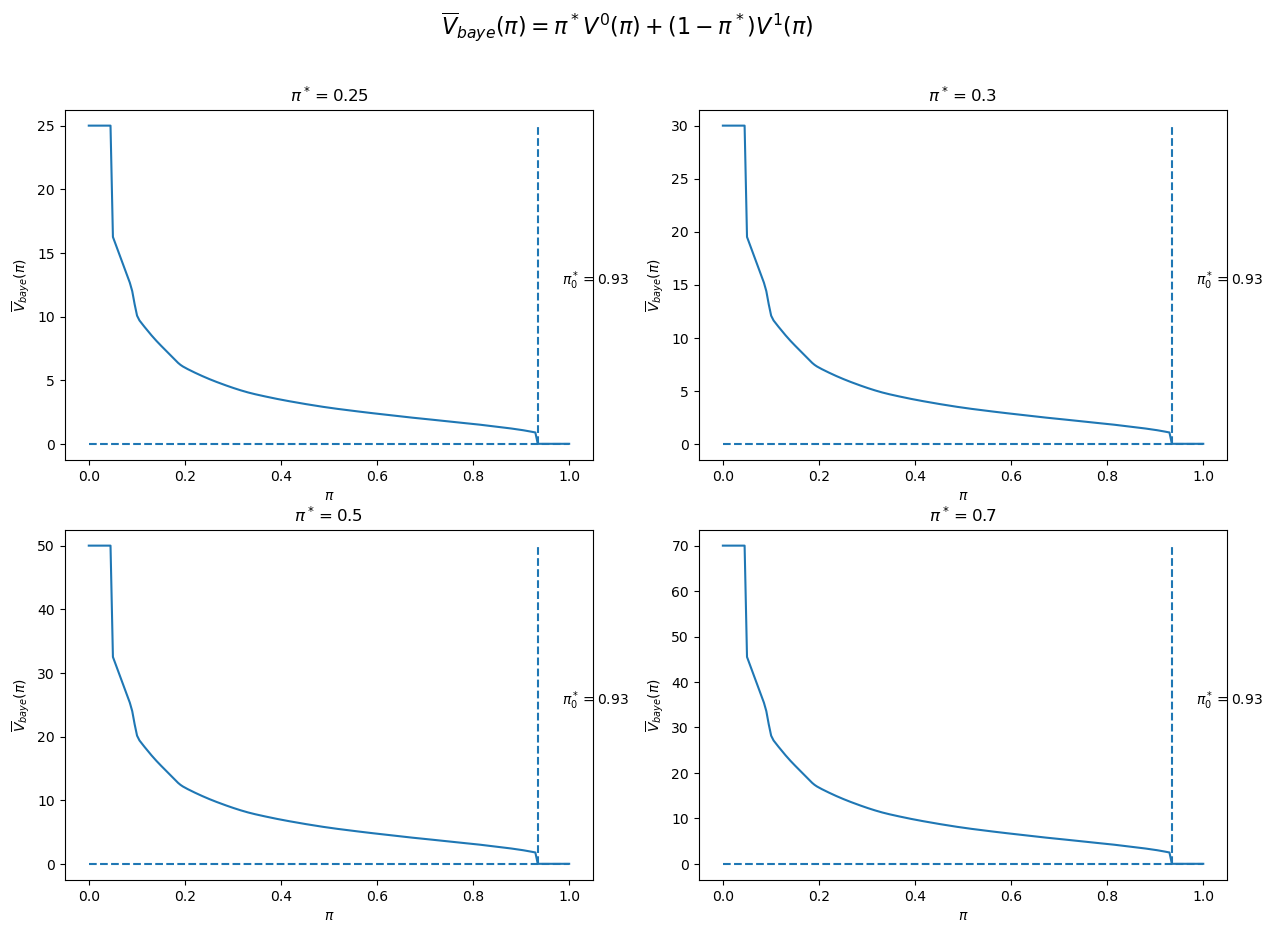

In [29]:
π_star_arr = [0.25, 0.3, 0.5, 0.7]

fig, axs = plt.subplots(2, 2, figsize=(15, 10))

for i, π_star in enumerate(π_star_arr):
    row_i = i // 2
    col_i = i % 2

    V_baye, π_optimal, V_baye_bar = compute_V_baye_bar(π_star, V0, V1, wf)

    axs[row_i, col_i].plot(wf.π_grid, V_baye)
    axs[row_i, col_i].hlines(V_baye_bar, 0, 1, linestyle='--')
    axs[row_i, col_i].vlines(π_optimal, V_baye_bar, V_baye.max(), linestyle='--')
    axs[row_i, col_i].text(π_optimal+0.05, (V_baye_bar + V_baye.max()) / 2,
                        '${\pi_0^*}=$'+f'{π_optimal:0.2f}')
    axs[row_i, col_i].set_xlabel('$\pi$')
    axs[row_i, col_i].set_ylabel('$\overline{V}_{baye}(\pi)$')
    axs[row_i, col_i].set_title('$\pi^*=$' + f'{π_star}')

fig.suptitle('$\overline{V}_{baye}(\pi)=\pi^*V^0(\pi) + (1-\pi^*)V^1(\pi)$', fontsize=16)
plt.show()

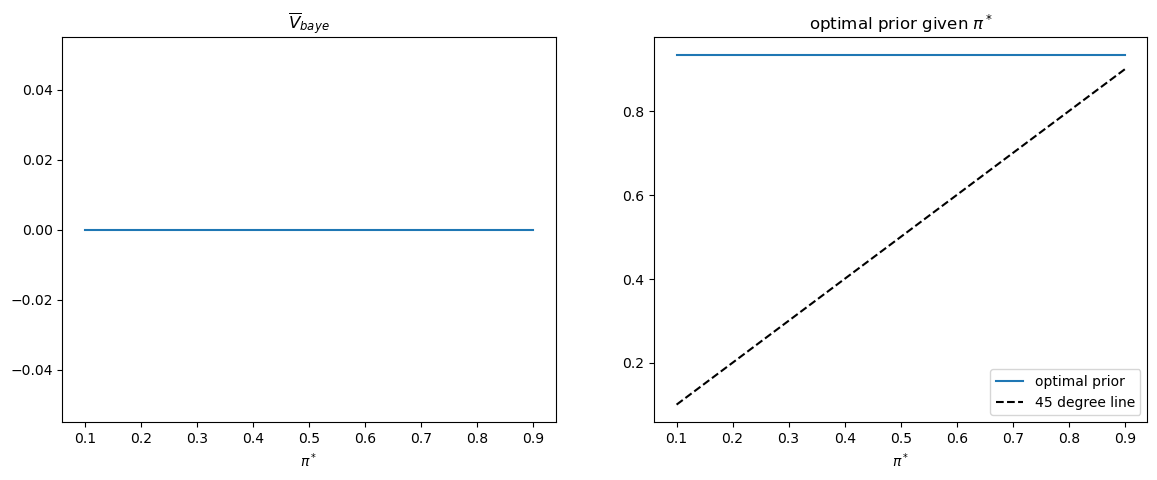

In [30]:
π_star_arr = np.linspace(0.1, 0.9, n_π)
V_baye_bar_arr = np.empty_like(π_star_arr)
π_optimal_arr = np.empty_like(π_star_arr)

for i, π_star in enumerate(π_star_arr):

    V_baye, π_optimal, V_baye_bar = compute_V_baye_bar(π_star, V0, V1, wf)

    V_baye_bar_arr[i] = V_baye_bar
    π_optimal_arr[i] = π_optimal

fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(π_star_arr, V_baye_bar_arr)
axs[0].set_xlabel('$\pi^*$')
axs[0].set_title('$\overline{V}_{baye}$')

axs[1].plot(π_star_arr, π_optimal_arr, label='optimal prior')
axs[1].plot([π_star_arr.min(), π_star_arr.max()],
            [π_star_arr.min(), π_star_arr.max()],
            c='k', linestyle='--', label='45 degree line')
axs[1].set_xlabel('$\pi^*$')
axs[1].set_title('optimal prior given $\pi^*$')
axs[1].legend()

plt.show()

In [31]:
π_star = 0.5

In [32]:
# frequentist
V_fre_arr, PFA_arr, PD_arr = compute_V_fre(L0_arr, L1_arr, π_star, wf)

# bayesian
V_baye = π_star * V0 + π_star * V1
V_baye_bar = V_baye.min()

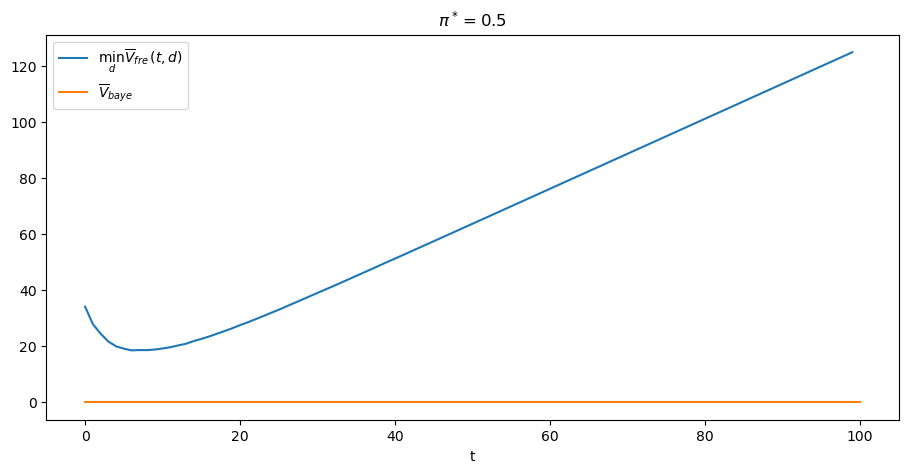

In [33]:
plt.plot(range(T), V_fre_arr, label='$\min_{d} \overline{V}_{fre}(t,d)$')
plt.plot([0, T], [V_baye_bar, V_baye_bar], label='$\overline{V}_{baye}$')
plt.xlabel('t')
plt.title('$\pi^*=0.5$')
plt.legend()
plt.show()

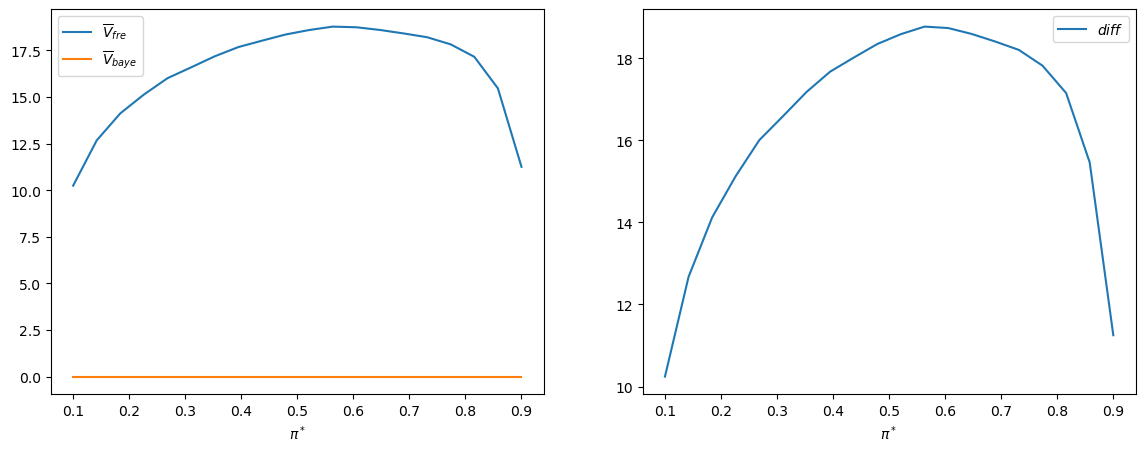

In [34]:
fig, axs = plt.subplots(1, 2, figsize=(14, 5))

axs[0].plot(π_star_arr, V_fre_bar_arr, label='$\overline{V}_{fre}$')
axs[0].plot(π_star_arr, V_baye_bar_arr, label='$\overline{V}_{baye}$')
axs[0].legend()
axs[0].set_xlabel('$\pi^*$')

axs[1].plot(π_star_arr, V_fre_bar_arr - V_baye_bar_arr, label='$diff$')
axs[1].legend()
axs[1].set_xlabel('$\pi^*$')

plt.show()

In [35]:
π_star = 0.5

In [36]:
t_optimal

7

In [37]:
t_idx = t_optimal - 1

In [38]:
@njit(parallel=True)
def check_results(L_arr, α, β, flag, π0):

    N, T = L_arr.shape

    time_arr = np.empty(N)
    correctness = np.empty(N)

    π_arr = π0 * L_arr / (π0 * L_arr + 1 - π0)

    for i in prange(N):
        for t in range(T):
            if (π_arr[i, t] < β) or (π_arr[i, t] > α):
                time_arr[i] = t + 1
                correctness[i] = (flag == 0 and π_arr[i, t] > α) or (flag == 1 and π_arr[i, t] < β)
                break

    return time_arr, correctness

In [39]:
time_arr0, correctness0 = check_results(L0_arr, α, β, 0, π_star)
time_arr1, correctness1 = check_results(L1_arr, α, β, 1, π_star)

# unconditional distribution
time_arr_u = np.concatenate((time_arr0, time_arr1))
correctness_u = np.concatenate((correctness0, correctness1))

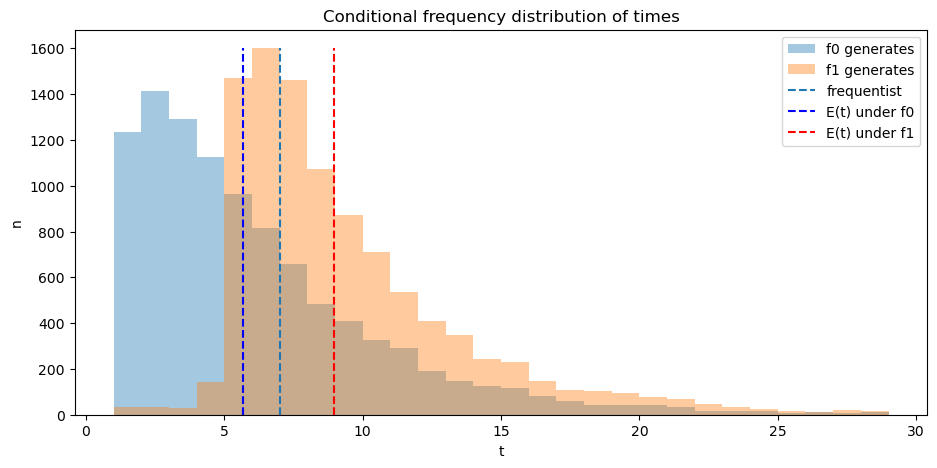

In [40]:
n1 = plt.hist(time_arr0, bins=range(1, 30), alpha=0.4, label='f0 generates')[0]
n2 = plt.hist(time_arr1, bins=range(1, 30), alpha=0.4, label='f1 generates')[0]
plt.vlines(t_optimal, 0, max(n1.max(), n2.max()), linestyle='--', label='frequentist')
plt.vlines(np.mean(time_arr0), 0, max(n1.max(), n2.max()),
           linestyle='--', color='b', label='E(t) under f0')
plt.vlines(np.mean(time_arr1), 0, max(n1.max(), n2.max()),
           linestyle='--', color='r', label='E(t) under f1')
plt.legend();

plt.xlabel('t')
plt.ylabel('n')
plt.title('Conditional frequency distribution of times')

plt.show()

In [41]:
π0_arr = π_star * L0_arr / (π_star * L0_arr + 1 - π_star)
π1_arr = π_star * L1_arr / (π_star * L1_arr + 1 - π_star)

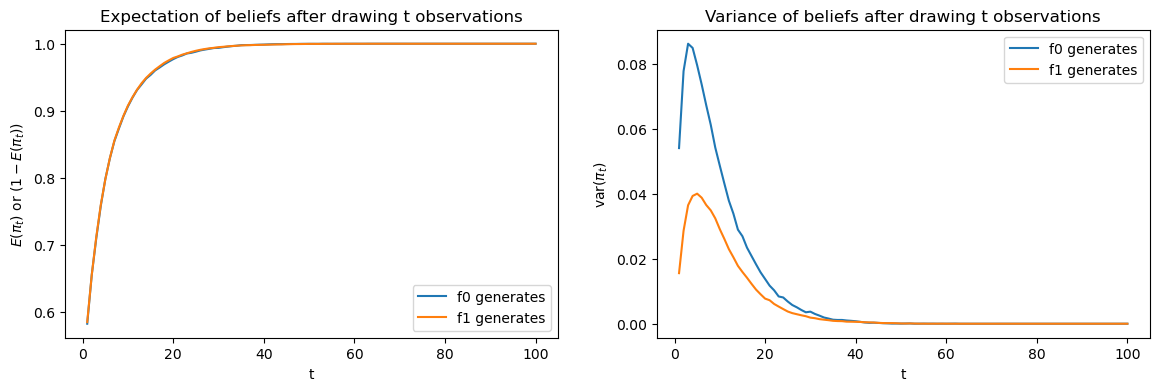

In [42]:
fig, axs = plt.subplots(1, 2, figsize=(14, 4))

axs[0].plot(np.arange(1, π0_arr.shape[1]+1), np.mean(π0_arr, 0), label='f0 generates')
axs[0].plot(np.arange(1, π1_arr.shape[1]+1), 1 - np.mean(π1_arr, 0), label='f1 generates')
axs[0].set_xlabel('t')
axs[0].set_ylabel('$E(\pi_t)$ or ($1 - E(\pi_t)$)')
axs[0].set_title('Expectation of beliefs after drawing t observations')
axs[0].legend()

axs[1].plot(np.arange(1, π0_arr.shape[1]+1), np.var(π0_arr, 0), label='f0 generates')
axs[1].plot(np.arange(1, π1_arr.shape[1]+1), np.var(π1_arr, 0), label='f1 generates')
axs[1].set_xlabel('t')
axs[1].set_ylabel('var($\pi_t$)')
axs[1].set_title('Variance of beliefs after drawing t observations')
axs[1].legend()

plt.show()

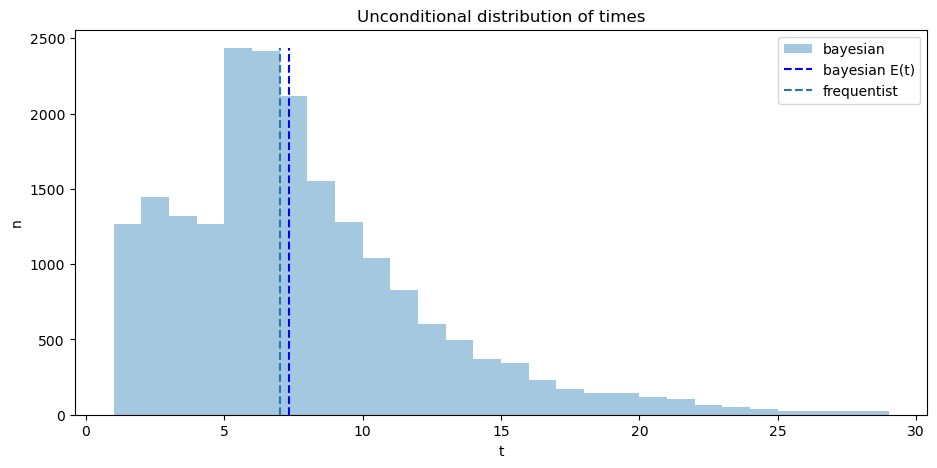

In [43]:
n = plt.hist(time_arr_u, bins=range(1, 30), alpha=0.4, label='bayesian')[0]
plt.vlines(np.mean(time_arr_u), 0, n.max(), linestyle='--',
           color='b', label='bayesian E(t)')
plt.vlines(t_optimal, 0, n.max(), linestyle='--', label='frequentist')
plt.legend()

plt.xlabel('t')
plt.ylabel('n')
plt.title('Unconditional distribution of times')

plt.show()

In [44]:
# optimal PFA and PD of frequentist with optimal sample size
V, PFA, PD = V_fre_t(t_optimal, L0_arr, L1_arr, π_star, wf)

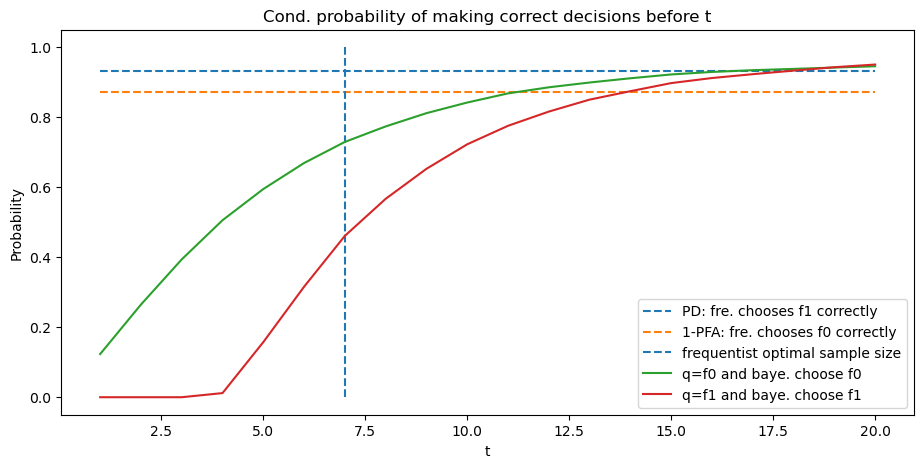

In [45]:
plt.plot([1, 20], [PD, PD], linestyle='--', label='PD: fre. chooses f1 correctly')
plt.plot([1, 20], [1-PFA, 1-PFA], linestyle='--', label='1-PFA: fre. chooses f0 correctly')
plt.vlines(t_optimal, 0, 1, linestyle='--', label='frequentist optimal sample size')

N = time_arr0.size
T_arr = np.arange(1, 21)
plt.plot(T_arr, [np.sum(correctness0[time_arr0 <= t] == 1) / N for t in T_arr],
        label='q=f0 and baye. choose f0')
plt.plot(T_arr, [np.sum(correctness1[time_arr1 <= t] == 1) / N for t in T_arr],
        label='q=f1 and baye. choose f1')
plt.legend(loc=4)

plt.xlabel('t')
plt.ylabel('Probability')
plt.title('Cond. probability of making correct decisions before t')

plt.show()

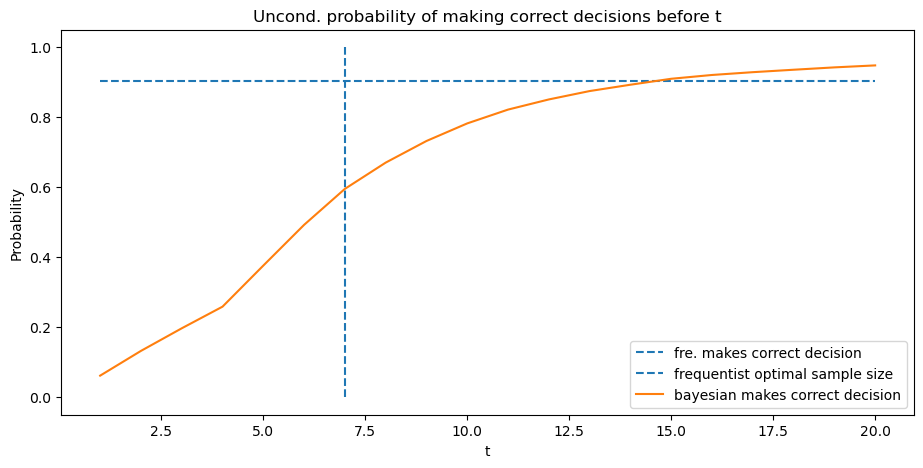

In [46]:
plt.plot([1, 20], [(PD + 1 - PFA) / 2, (PD + 1 - PFA) / 2],
        linestyle='--', label='fre. makes correct decision')
plt.vlines(t_optimal, 0, 1, linestyle='--', label='frequentist optimal sample size')

N = time_arr_u.size
plt.plot(T_arr, [np.sum(correctness_u[time_arr_u <= t] == 1) / N for t in T_arr],
        label="bayesian makes correct decision")
plt.legend()

plt.xlabel('t')
plt.ylabel('Probability')
plt.title('Uncond. probability of making correct decisions before t')

plt.show()

In [47]:
Lα = (1 - π_star) *  α / (π_star - π_star * α)
Lβ = (1 - π_star) *  β / (π_star - π_star * β)

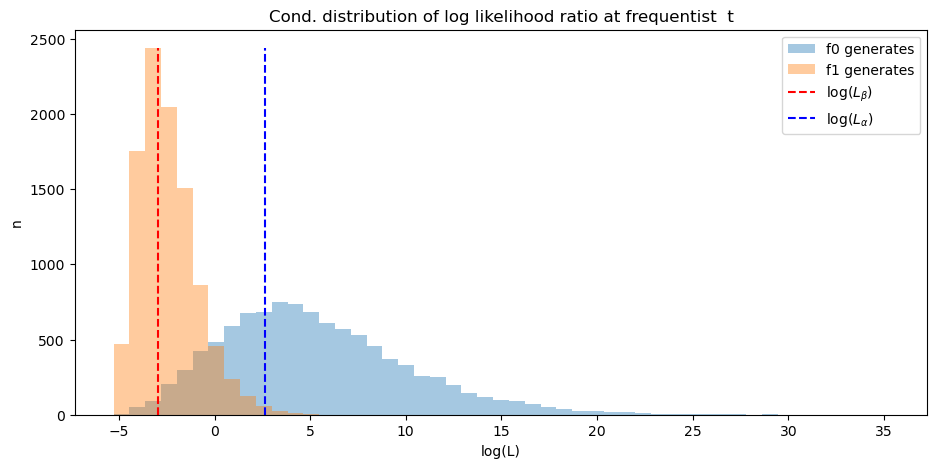

In [48]:
L_min = min(L0_arr[:, t_idx].min(), L1_arr[:, t_idx].min())
L_max = max(L0_arr[:, t_idx].max(), L1_arr[:, t_idx].max())
bin_range = np.linspace(np.log(L_min), np.log(L_max), 50)
n0 = plt.hist(np.log(L0_arr[:, t_idx]), bins=bin_range, alpha=0.4, label='f0 generates')[0]
n1 = plt.hist(np.log(L1_arr[:, t_idx]), bins=bin_range, alpha=0.4, label='f1 generates')[0]

plt.vlines(np.log(Lβ), 0, max(n0.max(), n1.max()), linestyle='--', color='r', label='log($L_β$)')
plt.vlines(np.log(Lα), 0, max(n0.max(), n1.max()), linestyle='--', color='b', label='log($L_α$)')
plt.legend()

plt.xlabel('log(L)')
plt.ylabel('n')
plt.title('Cond. distribution of log likelihood ratio at frequentist  t')

plt.show()

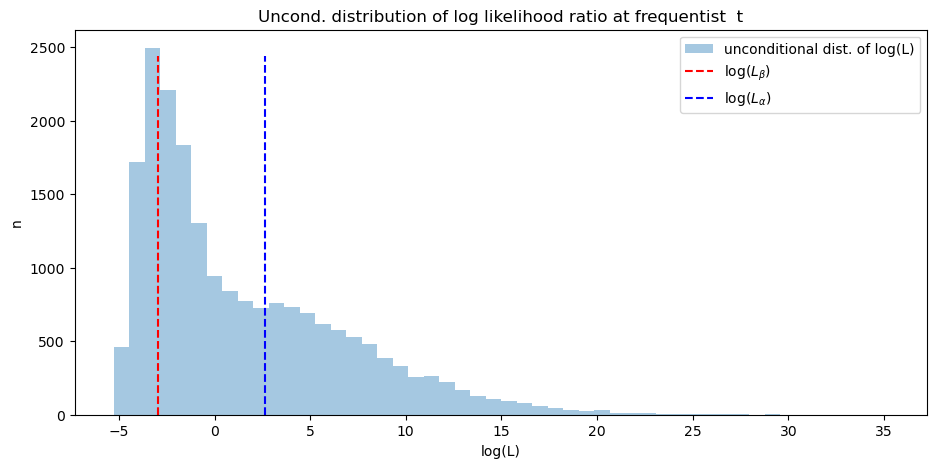

In [49]:
plt.hist(np.log(np.concatenate([L0_arr[:, t_idx], L1_arr[:, t_idx]])),
        bins=50, alpha=0.4, label='unconditional dist. of log(L)')
plt.vlines(np.log(Lβ), 0, max(n0.max(), n1.max()), linestyle='--', color='r', label='log($L_β$)')
plt.vlines(np.log(Lα), 0, max(n0.max(), n1.max()), linestyle='--', color='b', label='log($L_α$)')
plt.legend()

plt.xlabel('log(L)')
plt.ylabel('n')
plt.title('Uncond. distribution of log likelihood ratio at frequentist  t')

plt.show()